# Задание 1: классификация на синтетическом датасете

In [1]:
# Импортируем необходимые библиотеки
import pandas as pd
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, accuracy_score
# Зафиксируем случайность  и размер тестовой выборки
RANDOM_STATE = 42
TEST_SIZE = 0.30

## Генерация данных:

Сгенерируем датасет, содержащий 1000 наблюдений и 2 признака.

In [2]:
# Генерация
X, y = make_blobs(n_samples=1000, centers=2, cluster_std=3.8, center_box=(-6.0, 6.0), random_state=RANDOM_STATE)
# Запишем в датафрейм
df = pd.DataFrame({
    'feature_1': X[:, 0],
    'feature_2': X[:, 1],
    'class': y
})

## Разделение данных:

Разделим датасет на тренировочную и тестовую выборки в соотношении 70:30.

In [3]:
X_train, X_test, y_train, y_test = train_test_split(df.drop(columns='class'), df['class'], test_size=TEST_SIZE, random_state=RANDOM_STATE)

In [4]:
# Проверим разбиение
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((700, 2), (700,), (300, 2), (300,))

## Визуализация данных

Построим график рассеяния.

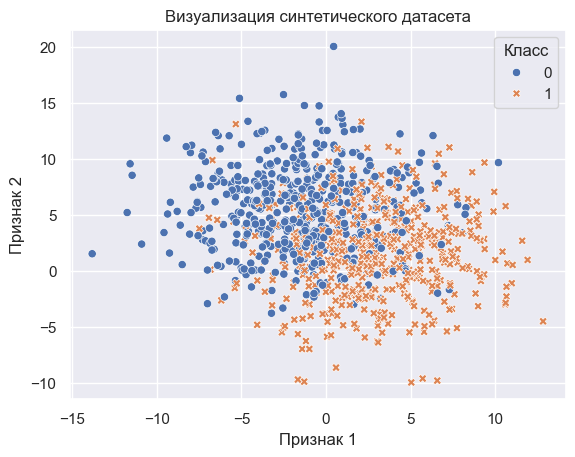

In [5]:
# Строим график
sns.scatterplot(data=df, x='feature_1', y='feature_2', hue='class', style='class', palette='deep')
plt.title("Визуализация синтетического датасета")
plt.xlabel("Признак 1")
plt.ylabel("Признак 2")
plt.legend(title='Класс')
plt.show()

На графике представлено распределение синтетических данных, сгенерированных методом make_blobs. Набор содержит два класса, центры которых расположены в пределах диапазона [-6, 6]. Высокое значение стандартного отклонения приводит к значительному наложению кластеров, что имитирует реальные условия с нечёткой границей между классами. Это усложняет задачу классификации и позволяет оценить качество модели при наличии шума.

## Масштабирование данных и подготовка пайплайна

Подготовим данные, признаки обработаем в пайплайне.

In [6]:
# Создаём пайплайн для подготовки данных
cols = ['feature_1', 'feature_2']
preprocessor = ColumnTransformer([('num', StandardScaler(), cols)])

# Создаём итоговый пайплайн: подготовка данных и модель
pipe = Pipeline(
    [
        ('preprocessor', preprocessor),
        ('models', LogisticRegression())
    ]
)

## Построение моделей

Напишем словарь для подбора лучших гиперпараметров.

In [7]:
param_grid = [
    
    # словарь для модели LogisticRegression()
    {
        'models': [LogisticRegression(random_state=RANDOM_STATE)],
        'models__C': [0.1, 1, 10]
    },

    # словарь для модели SVC()
    {
        'models':[SVC(random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10],
        'models__gamma': [0.01, 0.1, 1]
    },

    # словарь для модели DecisionTreeClassifier()
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': [5, 10, 20],
        'models__min_samples_split': [2, 5, 10]
    },
    # словарь для модели RandomForestClassifier()
    {
        'models': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'models__n_estimators': [10, 50, 100],
        'models__max_depth': [5, 10, 20]
    }
]

Используем один общий пайплайн для всех моделей и инструмент подбора гиперпараметров, который вернёт нам лучшую модель.

В качестве метрики возьмем встроенную в GridSearchCV ROC-AUC, так как имеем дело с бинарной классификацией. А тестировать будем через коэффициент Джини(связан по формуле 2⋅AUC−1).

In [8]:
# Производим подбор гиперпараметров с помощью RandomizedSearchCV
search = GridSearchCV(
    pipe, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    verbose=2
)
search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END models=LogisticRegression(random_state=42), models__C=0.1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=0.1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=0.1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=0.1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=0.1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=1; total time=   0.0s
[CV] END models=LogisticRegression(random_state=42), models__C=10; total time=

,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...egression())])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'models': [LogisticRegre...ndom_state=42)], 'models__C': [0.1, 1, ...]}, {'models': [SVC(probabili...ndom_state=42)], 'models__C': [0.1, 1, ...], 'models__gamma': [0.01, 0.1, ...]}, ...]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",None
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, t

In [9]:
print('Лучшая модель и её параметры:', search.best_estimator_)
print ('Метрика ROC-AUC лучшей модели на кросс-валидации:', search.best_score_)
print ('Метрика Gini лучшей модели на кросс-валидации:', 2 * search.best_score_ - 1)

Лучшая модель и её параметры: Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['feature_1',
                                                   'feature_2'])])),
                ('models',
                 SVC(C=10, gamma=0.01, probability=True, random_state=42))])
Метрика ROC-AUC лучшей модели на кросс-валидации: 0.8598729436661376
Метрика Gini лучшей модели на кросс-валидации: 0.7197458873322753


Выведем топ-10 моделей, их параметры и значения метрик на кросс-валидации.

In [10]:
results_df = pd.DataFrame(search.cv_results_)[['rank_test_score',
                                                          'param_models',
                                                          'mean_test_score',
                                                          'params',
                                                          'mean_fit_time',
                                                          'mean_score_time']].sort_values('rank_test_score').rename(columns={'mean_test_score':'AUC_score'})
results_df['Gini_score'] = 2 * results_df['AUC_score'] - 1

In [11]:
# Топ-10 моделей
results_df.head(10)

,rank_test_score,param_models,AUC_score,params,mean_fit_time,mean_score_time,Gini_score
9,1,"SVC(probability=True, random_state=42)",0.859873,"{'models': SVC(probability=True, random_state=...",0.053911,0.010868,0.719746
6,2,"SVC(probability=True, random_state=42)",0.859791,"{'models': SVC(probability=True, random_state=...",0.057764,0.010770,0.719583
0,3,LogisticRegression(random_state=42),0.859506,{'models': LogisticRegression(random_state=42)...,0.008446,0.005170,0.719011
1,4,LogisticRegression(random_state=42),0.859179,{'models': LogisticRegression(random_state=42)...,0.007288,0.004894,0.718358
2,4,LogisticRegression(random_state=42),0.859179,{'models': LogisticRegression(random_state=42)...,0.007646,0.004827,0.718358
3,6,"SVC(probability=True, random_state=42)",0.859057,"{'models': SVC(probability=True, random_state=...",0.082625,0.013415,0.718113
4,7,"SVC(probability=True, random_state=42)",0.857628,"{'models': SVC(probability=True, random_state=...",0.055354,0.009851,0.715256
7,8,"SVC(probability=True, random_state=42)",0.855016,"{'models': SVC(probability=True, random_state=...",0.052729,0.010604,0.710031
10,9,"SVC(probability=True, random_state=42)",0.849954,"{'models': SVC(probability=True, random_state=...",0.057226,0.009573,0.699909
23,10,RandomForestClassifier(random_state=42),0.847444,{'models': RandomForestClassifier(random_state...,0.182500,0.016358,0.694887


По результатам кросс-валидации наилучшее качество показали модели SVC и Logistic Regression, демонстрируя сопоставимые значения AUC (0.859-0.860) и коэффициента Джини (0.719-0.720).

Топ-3 конфигурации представлены линейными моделями, что указывает на умеренную нелинейность данных и эффективность регуляризации.
Random Forest оказался менее эффективен (Gini = 0.695), вероятно, из-за небольшого объёма данных или недостаточной глубины деревьев.

Все лучшие модели устойчивы к переобучению: разброс метрик между фолдами минимальный.

Logistic Regression выделяется высокой скоростью обучения (в 7–10 раз быстрее SVM), что делает её предпочтительной для задач с частым переобучением.

## Оценка качества моделей

Оценим качество моделей на тестовой выборке, используем коэффициент Джини.

In [12]:
y_test_proba = search.predict_proba(X_test)[:,1]
y_test_pred = search.predict(X_test)
print(f'Метрика Gini на тестовой выборке: {2 * roc_auc_score(y_test, y_test_proba)-1:.4f}')
print(f'Точность на тестовой выборке: {accuracy_score(y_test, y_test_pred):.4f}')

Метрика Gini на тестовой выборке: 0.8176
Точность на тестовой выборке: 0.8233


**Gini = 0.82** - модель отлично разделяет классы.

**Точность = 0.82** - можно доверять положительным прогнозам модели.

## **Итоговые выводы**

Таким образом мы создали синтетический датасет и обучили на нем модели для задачи классификации:

1. Построили модель для бинарной классификации.

Для этого были выполнены следующие действия:

- Сгенерирован датасет, содержащий 1000 наблюдений и 2 признака, разделили его на обучающую и тестовую выборку в соотношении 70:30
  
- Визуализировали данные, построили график рассеяния
    
- Применили пайплайны для подготовки признаков и обучения модели:

  масштабировали признаки с помощью StandardScaler

  перебрали гиперпараметры для линейных моделей и деревьев решений

- Выбрали лучшую модель, оценили качество на тесте с помощью метрики Gini :

    **SVC**(C=10, gamma=0.01, probability=True, random_state=42),
    **Gini = 0.82** - модель очень хорошо разделяет классы.
    **Точность = 0.82** - можно доверять положительным прогнозам модели.